In [124]:
#from utils import read_canonical_model, load_pc
# import autograd.numpy as np
#import utils
import numpy as np
from copy import deepcopy
import os
os.chdir("/Users/rich13/PointCloudPosePrediction")
from utils.utils import invert_pose
import importlib
import yaml
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
import transforms3d as t3d
import transforms3d.quaternions as tq
import transforms3d.axangles as ax
# from autograd import grad
from numpy.linalg import norm
from scipy.spatial.transform import Rotation as R
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import dgl.geometry
import numpy as np
# from .utils import read_canonical_model, load_pc, visualize_icp_result
# from icp_file import icp
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('TkAgg')
import torch
import core.pointnet as pnet
importlib.reload(pnet)
import utils.dataloader
import utils.utils
import utils.vision
importlib.reload(utils.utils)
importlib.reload(utils.vision)
importlib.reload(utils.dataloader)
import scipy.io as sio
import open3d as o3d
import cv2



def create_pose(R, p):

    T = np.zeros((4, 4))
    # R is 3x3
    # p is 3x1

    T[0:3, 0:3] = R
    T[0, 3] = p[0]
    T[1, 3] = p[1]
    T[2, 3] = p[2]
    T[3, 3] = 1

    return T

def create_rotation_along_z(theta):

    return np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])

# Multiply matrices
# Given matrices T1, T2, ..., Tn multiply Tn*Tn-1* ... *T1
def multiply_matrices(T):

    #Where T is of dimension (4, 4, # of iterations)

    for i in range(T.shape[2] -1):

        if i == 0:
            T_curr = T[:, :, i]

        T_next = T[:, :, i+1]
        T_curr = np.matmul(T_next, T_curr)

    return T_curr



def kabsch(point_cloud_z, point_cloud_m):

    # point_cloud_z is of dimension 3 by N
    # point_cloud_m is of dimension 3 by N



    #Compute the centroids
    cen_m = np.mean(point_cloud_m, axis = 1)
    cen_z = np.mean(point_cloud_z, axis = 1)

    #Copmute the distances of the point clouds to their center
    del_m = point_cloud_m - cen_m.reshape(3, 1)
    del_z = point_cloud_z - cen_z.reshape(3, 1)

    Q = np.zeros((3, 3))
    for k in range(point_cloud_m.shape[1]):
        # Q = Q + (del_m[:, k] * np.transpose(del_z[:, k]))
        Q = Q + np.outer(del_m[:, k], del_z[:, k])



    U, _, Vt = np.linalg.svd(Q) #Get SVD

    M = np.array([[1, 0, 0], [0, 1, 0], [0, 0, np.linalg.det(U @ Vt)]])
    R_next = U @ M @ Vt # Compute R_next

    #print(np.linalg.det(R_next))

    p_next = cen_m - np.dot(R_next, cen_z)


    return R_next, p_next, np.trace(np.matmul(Q.T, R_next))


# def make_association(source, target):
#
#     # Shapes for source and target are (n, dim) and (m, dim) respectively
#
#     dim = source.shape[1]
#     assert source.shape[1] == dim
#     assert target.shape[1] == dim
#
#     source = source.copy()
#     target = target.copy()
#     flip = False
#     if source.shape[0] < target.shape[0]:
#         flip = True
#         source, target = target, source
#
#     assert source.shape[0] >= target.shape[0]
#
#     # Build Tree for Smallest pt cloud
#     tree = KDTree(source)
#
#     _, delta = tree.query(target)
#
#     z = source[delta]
#
#     if flip:
#         z, target = target, z
#
#     return z, target




def read_canonical_model(model_name):
  '''
  Read canonical model from .mat file
  model_name: str, 'drill' or 'liq_container'
  return: numpy array, (N, 3)
  '''

  current_directory = os.path.dirname(__file__)
  model_fname = os.path.join(current_directory, 'data', model_name, 'model.mat')
  model = sio.loadmat(model_fname)

  cano_pc = model['Mdata'].T / 1000.0 # convert to meter

  return cano_pc


def load_pc(model_name, id):
  '''
  Load point cloud from .npy file
  model_name: str, 'drill' or 'liq_container'
  id: int, point cloud id
  return: numpy array, (N, 3)
  '''
  current_directory = os.path.dirname(__file__)
  pc_fname = os.path.join(current_directory, 'data', model_name, '%d.npy' % id)
  pc = np.load(pc_fname)

  return pc


def visualize_icp_result(source_pc, target_pc, pose):
  '''
  Visualize the result of ICP
  source_pc: numpy array, (N, 3)
  target_pc: numpy array, (N, 3)
  pose: SE(4) numpy array, (4, 4)
  '''
  source_pcd = o3d.geometry.PointCloud()
  source_pcd.points = o3d.utility.Vector3dVector(source_pc.reshape(-1, 3))
  source_pcd.paint_uniform_color([0, 1, 1])

  target_pcd = o3d.geometry.PointCloud()
  target_pcd.points = o3d.utility.Vector3dVector(target_pc.reshape(-1, 3))
  target_pcd.paint_uniform_color([1, 0, 0])

  source_pcd.transform(pose)
  #target_pcd.transform(np.linalg.inv(pose))

  o3d.visualization.draw_geometries([source_pcd, target_pcd])







def icp(iters, target, source, R_curr, p_curr):


    #Number of points to sample from the cloud
#     num_sampled_pts = 5 

    point_cloud_m = target

    point_cloud_z = source
    #sampled_point_cloud_z = np.transpose(point_cloud_z[np.random.choice(point_cloud_z.shape[0], num_sampled_pts, replace=False)])
    #sampled_point_cloud_z = np.transpose(point_cloud_z[::num_sampled_pts])
    sampled_point_cloud_z = np.transpose(point_cloud_z)


    # Build a tree
    #tree_source = KDTree(point_cloud_z)
    #sampled_point_cloud_z = np.transpose(point_cloud_z)


    T_final = np.zeros((4, 4))
    #T_save = np.zeros((4, 4, iters + 1))
    #loss = np.zeros(iters)
    #print("Begin ICP")



    #T_save[:, :, 0] = create_pose(R_curr, p_curr)
    prev_loss = np.inf
    for j in range(iters):



        # Create the Data Association
        trans_sampled_point_cloud_z = np.transpose(np.matmul(R_curr, sampled_point_cloud_z) + p_curr.reshape(3, 1))
        #trans_sampled_point_cloud_m = np.transpose(R_curr) @ (np.transpose(point_cloud_m) - p_curr.reshape(3, 1))
        #delta = np.argmin(np.sum((trans_sampled_point_cloud_z[:, np.newaxis, :] - point_cloud_m) ** 2, axis = -1), axis = 1) #Source to target
        tree = KDTree(trans_sampled_point_cloud_z)



        #delta = find_nbr(trans_sampled_point_cloud_z, point_cloud_m)
        _, delta = tree.query(point_cloud_m, k = 1)
        loss = np.mean(np.linalg.norm(np.transpose(np.transpose(sampled_point_cloud_z)[delta]) - point_cloud_m.T, axis = 1))

        if abs(prev_loss - loss) < 1e-6:
            break
        prev_loss = loss

        #z, m = make_association(trans_sampled_point_cloud_z, point_cloud_m)

        #Define new point cloud bases on the Data association
        #new_point_cloud_m = np.zeros((3, len(delta)))
        #for k in range(len(delta)):
            #new_point_cloud_m[:, k] = np.transpose(point_cloud_m[delta[k], :])

        #Call Kabsch
        # Which will give us the optimal orientation and translation between the two point clouds

        # sampled_point_cloud_z = sampled_point_cloud_z.T
        #R_next, p_next, _ = kabsch(sampled_point_cloud_z, np.transpose(point_cloud_m[delta]))
        R_next, p_next, _ = kabsch(np.transpose(np.transpose(sampled_point_cloud_z)[delta]), point_cloud_m.T)
        #print(z.shape)
        #print(m.shape)
        #3R_next, p_next, _ = kabsch((R_curr.T @ (z.T - p_curr.reshape(3, 1))), np.transpose(m))

        # Maybe put a stopping point
        #loss[j] = np.trace((((np.dot(R_next, sampled_point_cloud_z) + p_next.reshape(3, 1)) - new_point_cloud_m).T @ ((np.dot(R_next, sampled_point_cloud_z) + p_next.reshape(3, 1)) - new_point_cloud_m)))

        #Update
        #sampled_point_cloud_z = np.transpose(point_cloud_z[np.random.permutation(num_sampled_pts)])
        
        

        
        
        # Update
        R_curr = R_next
        p_curr = p_next



    T_final = create_pose(R_curr, p_curr)


    return T_final, _








def test(obj_name, num_pc, est_pose):

  source_pc = read_canonical_model(obj_name)
  #source_pc = source_pc[::50]

  #sampled_point_cloud_z = source_pc[np.random.permutation(5000)]

  for i in range(num_pc):
    target_pc = load_pc(obj_name, i)

    # estimated_pose, you need to estimate the pose with ICP
    pose = est_pose[:, :, i]
    #pose = est_pose


    # visualize the estimated result
    visualize_icp_result(source_pc, target_pc, pose)



with open("./models/run_1.yaml") as f:
    params = yaml.safe_load(f)

    
dataset= utils.dataloader.EdenDataset("/Users/rich13/PointCloudPosePrediction/sample",
                                            train=True,
                                            use_keypt_downsample = True,
                                            keypt_method=params['keypoint_detection']['detection_method']
#                                             pcd_num_pts=params['keypoint_detection']['pcd_num_pts']
                                            )

edenLoader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=1)

In [125]:
# create a batch for dev/testing purposes
# batch = next(iter(edenLoader))

In [126]:
# print(batch['pcd1'][0].shape)
# print(batch['pcd2'][0].shape)
# print(batch['pose'][0].shape)

In [127]:
# visualize_icp_result(dataset[0]['pcd1'], dataset[0]['pcd2'], np.eye(4))

In [128]:
# dataset[1]

In [129]:
# dataset[1]['pcd1']==dataset[0]['pcd2']

In [130]:
positions = np.zeros((500, 3))
for j in range(100):
    positions[j] = invert_pose(dataset[j]['pose'])[:3,3] # ground truth poses 

In [131]:
# get pt clouds from open3d library

0
Rel Pose from ICP [[ 1.00000002e+00 -2.64639460e-05 -4.52836440e-05  2.11443093e-05]
 [ 2.63724629e-05  9.99999933e-01  2.12384003e-04  1.94850322e-05]
 [ 4.52499499e-05 -2.12369619e-04  9.99999976e-01  2.62390905e-06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initialization angle to ICP:  -5.2429310646979474e-08
ICP output angle 0.0002178182519920387
    
Translation initialization to ICP:  [0. 0. 0.]
ICP translation output:  [2.11443093e-05 1.94850322e-05 2.62390905e-06]
1
Rel Pose from ICP [[ 1.00000002e+00 -5.05475348e-08 -1.40474425e-08  3.83029962e+01]
 [-5.05475348e-08  9.99999955e-01  7.78660296e-09 -3.21389933e+01]
 [-1.40474425e-08  7.78660296e-09  1.00000000e+00 -1.95004635e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Initialization angle to ICP:  -5.2429310646979474e-08
ICP output angle -5.2429310646979474e-08
    
Translation initialization to ICP:  [ 38.30299618 -32.13899325  -0.19500463]
ICP translation output:  [ 3

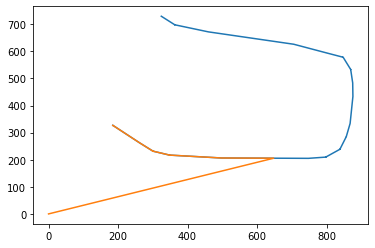

In [138]:
# ICP with ground truth

batch_size = 64 # number of times stamps
poses = np.zeros((4, 4, batch_size))
poses[:, :, 0] = invert_pose(dataset[0]['pose']) # Pose of the robot in body frame at time t = 0
poses[:, :, 0][:3, 3] = poses[:, :, 0][:3, 3] * 100

error_p = np.zeros(batch_size)
error_R = np.zeros(batch_size)

source = o3d.geometry.PointCloud()
target = o3d.geometry.PointCloud()

threshold = 0.02 # thresholf for ICP
for i in range(batch_size - 1):
    
    print(i)
    
    
    source.points = o3d.utility.Vector3dVector(dataset[i]['pcd1'].numpy())
    target.points = o3d.utility.Vector3dVector(dataset[i]['pcd2'].numpy())
    
    
    trans_init = dataset[i]['rel_pose'].numpy()
    trans_init[:3, 3] = dataset[i]['rel_pose'][:3, 3].numpy() * 100
        

    
    reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
    print("Rel Pose from ICP", reg_p2p.transformation)
    
    
    
    
#     source = np.transpose(dataset[i]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd1'].numpy() - dataset[i]['pose'][:3, 3].numpy()).T
#     target = np.transpose(dataset[i + 1]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd2'].numpy() - dataset[i + 1]['pose'][:3, 3].numpy()).T
    
    # initialize
#     p_initial = dataset[i]['translation'].numpy() 
#     R_initial = R.from_quat(dataset[i]['quat']) # Rotation between t+1 and t
    
    #pose_initial = icp(5, target, source, np.eye(3), p_initial) # get initial rotation
    
    # Run ICP to get the pose at the next time step t_T_t+1
#     rel_pose, _ = icp(iters, target, source, dataset[i]['rel_pose'][0:3, 0:3], dataset[i]['rel_pose'][:3, 3])
    
#     R_rel = rel_pose[0:3, 0:3] # relative rotation from icp
#     p_rel = rel_pose[:3, 3] # relative translation from icp
    
    error_p[i] = np.linalg.norm(reg_p2p.transformation[:3, 3] - trans_init[:3, 3])
    error_R[i] = ax.mat2axangle(np.matmul(trans_init[0:3, 0:3].T, reg_p2p.transformation[0:3, 0:3]))[1]
    

    
    
    print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
    print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    
    print("    ")
#     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
    print("Translation initialization to ICP: ", trans_init[:3, 3])
    
#     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    print("ICP translation output: ", reg_p2p.transformation[:3, 3])
    
    if i == 15:
        break

    #estimate pose at the next time step
    poses[:, :, i + 1] = np.matmul(reg_p2p.transformation, poses[:, :, i]) # world to body pose
    
    
    
#     #Update
#     prev_rel_pose = reg_p2p.transformation # relative pose estimated by ICP
plt.plot(positions[:batch_size,0] * 100,positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

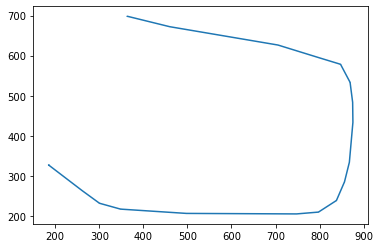

In [361]:
# plt.plot(positions[:batch_size,0] * 100,positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

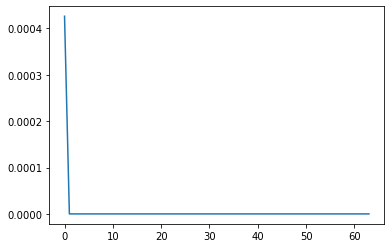

In [363]:
# plt.plot(error_R)
plt.plot(error_p)
plt.show()

In [57]:
dataset[54]['pose']

tensor([[-8.7852e-01,  4.7771e-01,  4.0847e-08,  1.7796e+00],
        [-4.0847e-08, -1.1115e-07, -1.0000e+00,  5.0160e-01],
        [-4.7771e-01, -8.7852e-01, -1.1115e-07,  8.4094e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [58]:
dataset[55]['pose']

tensor([[-8.7852e-01,  4.7771e-01,  4.0847e-08,  1.3040e+00],
        [-4.0847e-08, -1.1115e-07, -1.0000e+00,  5.0000e-01],
        [-4.7771e-01, -8.7852e-01, -1.1115e-07,  8.2549e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [59]:
np.dot(utils.utils.invert_pose(dataset[55]['pose']), dataset[54]['pose'])

array([[ 9.99999559e-01,  5.69479336e-08,  5.80596214e-08,
        -4.91569875e-01],
       [ 5.69479336e-08,  9.99999768e-01,  2.28307959e-07,
         9.14294366e-02],
       [ 5.80596214e-08,  2.28307959e-07,  9.99999762e-01,
        -1.60002464e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [60]:
new_pose = dataset[55]['rel_pose']
new_pose[:3, 3] = dataset[55]['rel_pose'][:3, 3] 
visualize_icp_result(dataset[55]['pcd1'], dataset[55]['pcd2'], invert_pose(new_pose))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62


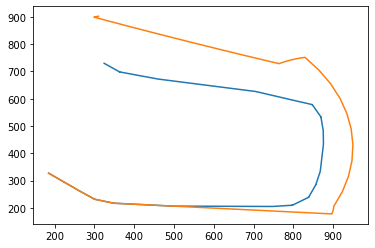

In [142]:
# visualize the trajectory of a sequence

batch_size = 64 # number of times stamps
iters = 100
poses = np.zeros((4, 4, batch_size))
poses[:, :, 0] = invert_pose(dataset[0]['pose']) # Pose of the robot in body frame at time t = 0
poses[:, :, 0][:3, 3] = poses[:, :, 0][:3, 3] * 100


error_p = np.zeros(batch_size)
error_R = np.zeros(batch_size)

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize

source = o3d.geometry.PointCloud()
target = o3d.geometry.PointCloud()

threshold = 0.02 # thresholf for ICP
for i in range(batch_size - 1):
    print(i)

    
    source.points = o3d.utility.Vector3dVector(dataset[i]['pcd1'].numpy())
    target.points = o3d.utility.Vector3dVector(dataset[i]['pcd2'].numpy())
    
    
#     trans_init = np.eye(4)
    
    if i < 10 or i % 10 == 0: # at the beginning I only have ground truth rel pose
        trans_init = dataset[i]['rel_pose'].numpy()
#         trans_init[:3, 3] = dataset[i]['rel_pose'][:3, 3].numpy() * 100
#         trans_init = np.eye(4)
        trans_init[0, 3] =  dataset[i]['rel_pose'][0, 3].numpy() * 100
        trans_init[1, 3] =  dataset[i]['rel_pose'][1, 3].numpy() * 100

    else:
        trans_init = deepcopy(reg_p2p.transformation) # assumes model continuity , initialize ICP with prev rel pose
#         print(trans_init)
#         trans_init[:3, 3] = trans_init[:3, 3] * 100
#         trans_init = dataset[i]['rel_pose'].numpy() * 100

    
        
        
    
    reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
#     print(reg_p2p.transformation)
        
    
#     source = np.transpose(dataset[i]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd1'].numpy() - dataset[i]['pose'][:3, 3].numpy()).T
#     target = np.transpose(dataset[i + 1]['pose'])[0:3, 0:3].numpy() @ (dataset[i]['pcd2'].numpy() - dataset[i + 1]['pose'][:3, 3].numpy()).T
    
    # initialize
#     p_initial = dataset[i]['translation'].numpy() 
#     R_initial = R.from_quat(dataset[i]['quat']) # Rotation between t+1 and t
    
    #pose_initial = icp(5, target, source, np.eye(3), p_initial) # get initial rotation
    
    # Run ICP to get the pose at the next time step t_T_t+1
#     rel_pose, _ = icp(iters, target, source, dataset[i]['rel_pose'][0:3, 0:3], dataset[i]['rel_pose'][:3, 3])
    
#     R_rel = rel_pose[0:3, 0:3] # relative rotation from icp
#     p_rel = rel_pose[:3, 3] # relative translation from icp
    
#     error_p[i] = np.linalg.norm(p_rel - dataset[i]['rel_pose'].numpy()[:3, 3])
#     error_R[i] = ax.mat2axangle(np.matmul(R_rel, dataset[i]['rel_pose'][0:3, 0:3]))[1]

        
#     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
#     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
    
#     print("    ")
# #     print("Initialization angle to ICP: ", ax.mat2axangle(trans_init[0:3, 0:3])[1])
#     print("Translation initialization to ICP: ", trans_init[:3, 3])
    
# #     print("ICP output angle", ax.mat2axangle(reg_p2p.transformation[0:3, 0:3])[1])
#     print("ICP translation output: ", reg_p2p.transformation[:3, 3])
    
#     print("")
    
#     if i == 50:
    
#         break

    #estimate pose at the next time step
    poses[:, :, i + 1] = np.matmul(reg_p2p.transformation, poses[:, :, i]) # world to body pose
#     poses[:, :, i + 1] = np.matmul(poses[:, :, i], reg_p2p.transformation) # world to body pose
    
    
    
    #Update
#     prev_rel_pose = reg_p2p.transformation # relative pose estimated by ICP
    

# Invert poses for plotting purposes
# for i in range(64):
#     poses[:, :, i] = invert_pose(poses[:, :, i])




plt.plot(positions[:batch_size,0] * 100, positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

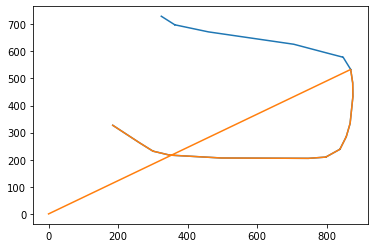

In [112]:
plt.plot(positions[:batch_size,0] * 100, positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

In [93]:
visualize_icp_result(dataset[0]['pcd1'], dataset[1]['pcd1'], dataset[0]['rel_pose'])

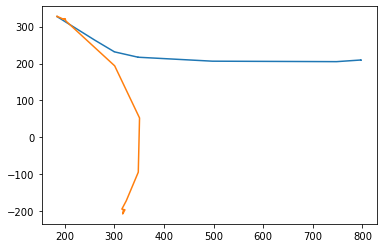

In [14]:
plt.plot(positions[:batch_size,0] * 100,positions[:batch_size,1] * 100)
plt.plot(poses[0, -1, :], poses[1, -1, :])
plt.show()

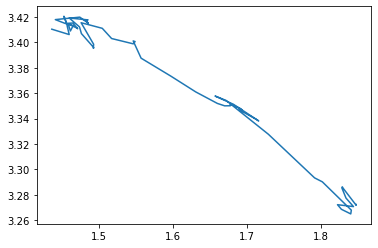

In [249]:
plt.plot(poses[0, -1, :], poses[1, -1, :])

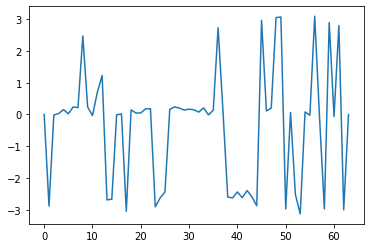

In [159]:
# plt.plot(error_p)
plt.plot(error_R)
plt.show()

In [138]:
visualize_icp_result(dataset[0]['pcd1'], dataset[1]['pcd2'], np.eye(4))

In [101]:
# import math

# print("quaternion 0:", math.degrees(2*np.arccos(dataset[0]['quat'][:-1]))[1])
# print("translation 0: ", dataset[0]['translation'])

# print("quaternion 1:",  math.degrees(tq.quat2axangle(dataset[1]['quat'])[1]))
# print("translation 1: ", dataset[1]['translation'])


# print("quaternion 2:", math.degrees(tq.quat2axangle(dataset[2]['quat'])[1]))
# print("translation 2: ", dataset[2]['translation'])


# print("quaternion 3:", math.degrees(tq.quat2axangle(dataset[3]['quat'])[1]))
# print("translation 3: ", dataset[3]['translation'])

ValueError: only one element tensors can be converted to Python scalars

In [77]:
math.degrees(ax.mat2axangle(dataset[3]['rel_pose'][0:3, 0:3])[1])

1.3189690420760594

(array([ 4.14964546e-07, -5.86314060e-07,  1.00000000e+00]),
 -0.023020339748918085)

In [52]:
print(dataset[1]['quat'])
print(dataset[1]['translation'])

tensor([[ 5.2992e-01, -8.4805e-01,  7.3725e-08,  1.3208e+00],
        [ 7.3725e-08, -5.7431e-08, -1.0000e+00,  5.0105e-01],
        [ 8.4805e-01,  5.2992e-01,  2.4302e-08, -3.4551e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [ ]:
im1 = cv2.imread('sample/rgb/0001/clear/A_0003_L.png')
im2 = cv2.imread('sample/rgb/0001/clear/A_0004_L.png')



plt.imshow(im1, cmap = 'gray')

In [ ]:
plt.imshow(im2, cmap = 'gray')